### Ignore Futrue Warnings

In [1]:
import warnings

# Ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import Dependencies

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Read the Given Dataset

In [7]:
# Load the datasets
train_data = pd.read_csv('solar-production-and-load-prediction-competition/train_data.csv')
test_data = pd.read_csv('solar-production-and-load-prediction-competition/test_data_masked.csv')
systems_data = pd.read_csv('solar-production-and-load-prediction-competition/systems_new.csv')

### Dtype the Datatime
The dtype of the `timestamp` was object. which was not good for the datasat, as timestamp is the most crucial feature in our dataset.

In [9]:
# Ensure the timestamp column is properly parsed
train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])
test_data['timestamp'] = pd.to_datetime(test_data['timestamp'])

# Data Cleaning
Data Cleaning is one of the most important preprocess step beforee training the model. Uncleaned data may lead our model in other side

In [11]:
train_data.duplicated().sum()

79551

In [12]:
train_data = train_data.drop_duplicates()

In [14]:
train_data.duplicated().sum()

0

In [19]:
train_data.isna().sum()

system_id       0
timestamp       0
generation_W    0
load_W          0
dtype: int64

### Timestatmp Missing:
In the dattaset, when we checked the `isna()` values, we get zero null values, but isna() don't help you with the data that's not in the timestamp, like inn out dataset, we have the timestamp of the time interavl 10min, if ther's no data for the complete hour, means the data is missing from the datast, so we have to add them inn order to make the dta frame absolute

In [22]:
def reindex_per_system_id(df, freq='10min'):
    # Determine the global minimum and maximum timestamp across the entire dataset
    global_min_timestamp = df['timestamp'].min()
    global_max_timestamp = df['timestamp'].max()
    
    # Create the complete global timestamp range
    full_range = pd.date_range(start=global_min_timestamp, end=global_max_timestamp, freq=freq)
    
    reindexed_data = []
    
    # Group by system_id and reindex based on the global full timestamp range for each system
    for system_id, group in df.groupby('system_id'):
        # Reindex the group with the global full timestamp range
        group = group.set_index('timestamp').reindex(full_range)
        
        # Reset the index and add back the system_id
        group = group.reset_index().rename(columns={'index': 'timestamp'})
        group['system_id'] = system_id
        
        reindexed_data.append(group)
    
    # Concatenate all reindexed groups back into a single DataFrame
    return pd.concat(reindexed_data, ignore_index=True)

In [24]:
# # Function to reindex each system_id separately
# def reindex_per_system_id(df, freq='10min'):
#     reindexed_data = []
#     # Group by system_id and reindex based on a full timestamp range for each system
#     for system_id, group in df.groupby('system_id'):
#         # Create a complete timestamp range for the current group
#         full_range = pd.date_range(start=group['timestamp'].min(), end=group['timestamp'].max(), freq=freq)
#         # Reindex the group
#         group = group.set_index('timestamp').reindex(full_range)
#         # Reset the index and add back the system_id
#         group = group.reset_index().rename(columns={'index': 'timestamp'})
#         group['system_id'] = system_id
#         reindexed_data.append(group)
#     # Concatenate all reindexed groups back into a single DataFrame
#     return pd.concat(reindexed_data, ignore_index=True)

In [26]:
# Apply the function to your train_data
train_data_reindexed = reindex_per_system_id(train_data)

After filling the missing timestamp, we get a lot of nan values in our dataset, now to fill that gap was crucial sensitive, it deponds on the nature of dataset, how ca can fll that data

In [29]:
train_data_reindexed.head() 

,timestamp,system_id,generation_W,load_W
0,2023-08-01 11:00:00,3,NaN,NaN
1,2023-08-01 11:10:00,3,NaN,NaN
2,2023-08-01 11:20:00,3,NaN,NaN
3,2023-08-01 11:30:00,3,NaN,NaN
4,2023-08-01 11:40:00,3,NaN,NaN


In [31]:
train_data_reindexed.isna().sum()

timestamp            0
system_id            0
generation_W    742985
load_W          742985
dtype: int64

In [33]:
train_data_reindexed = train_data_reindexed.set_index(train_data_reindexed['timestamp'])

## Visulatization after reindexing
In the graph, we can see the original dataset plot and the modified one. Just by reindexing, we were able to controll a big number error from the original, like the outliers etc

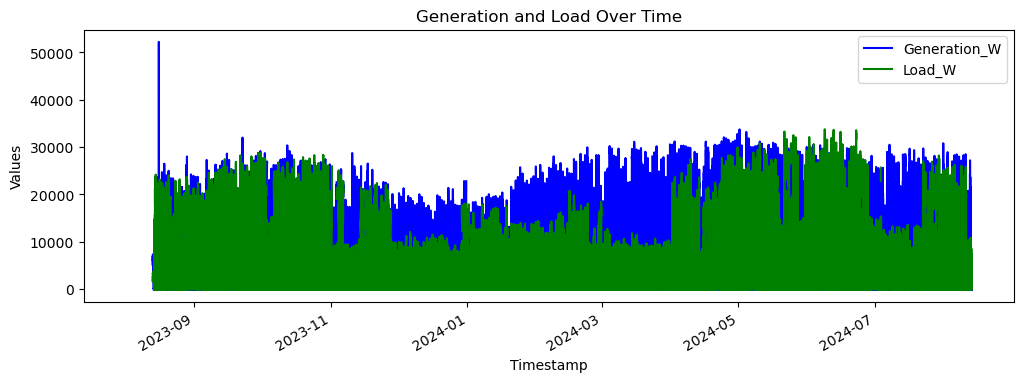

In [36]:
# Plot the first line for generation_W
train_data_reindexed['generation_W'].plot(kind='line', figsize=(12, 4), label='Generation_W', color='blue')

# Plot the second line for load_W (assuming you want to plot this as the second line)
train_data_reindexed['load_W'].plot(kind='line', figsize=(12, 4), label='Load_W', color='green')

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.title('Generation and Load Over Time')

# Add a legend to distinguish between the two lines
plt.legend()

# Show the plot
plt.show()

# Find the best value for your model

In [38]:
# Convert the timestamp to datetime if it's not already
train_data_reindexed['timestamp'] = pd.to_datetime(train_data_reindexed['timestamp'])

# Extract the hour from the timestamp
train_data_reindexed['hour'] = train_data_reindexed['timestamp'].dt.hour

**Lookinng for the timestamp which is the night time, so the generatin is zero, but if the data is present then it's the error in the dataset**

In [42]:
# Define nighttime hours (6 PM to 6 AM)
nighttime_df = train_data_reindexed[(train_data_reindexed['hour'] >= 19) | (train_data_reindexed['hour'] < 5)]

# Find instances where generation_W is greater than zero during nighttime
generation_at_night = nighttime_df[nighttime_df['generation_W'] > 0]

# Display the results
print(f"Number of instances where generation_W is greater than zero during nighttime: {len(generation_at_night)}\n")
generation_at_night[['timestamp', 'system_id', 'generation_W', 'load_W']].head()

Number of instances where generation_W is greater than zero during nighttime: 21265



,timestamp,system_id,generation_W,load_W
timestamp,,,,
2023-08-14 19:00:00,2023-08-14 19:00:00,3,45.0,814.00001
2023-08-14 19:10:00,2023-08-14 19:10:00,3,40.0,715.50000
2023-08-15 19:00:00,2023-08-15 19:00:00,3,45.0,831.00000
2023-08-15 19:10:00,2023-08-15 19:10:00,3,37.0,824.00000
2023-08-16 19:00:00,2023-08-16 19:00:00,3,47.0,796.50000


**Fixing the Night time generation error:**
If the valus found, the value will be replaced by zero, which is the actual value of the dataset

In [45]:
# Convert the timestamp to datetime if it's not already
train_data_reindexed['timestamp'] = pd.to_datetime(train_data_reindexed['timestamp'])

# Extract the hour from the timestamp
train_data_reindexed['hour'] = train_data_reindexed['timestamp'].dt.hour

# Define nighttime hours (6 PM to 6 AM)
nighttime_condition = (train_data_reindexed['hour'] >= 19) | (train_data_reindexed['hour'] < 5)

# Set generation_W to zero during nighttime
train_data_reindexed.loc[nighttime_condition, 'generation_W'] = 0

# Optionally, drop the 'hour' column if it's no longer needed
train_data_reindexed = train_data_reindexed.drop(columns=['hour'])

# Display the updated DataFrame
train_data_reindexed.head()

,timestamp,system_id,generation_W,load_W
timestamp,,,,
2023-08-01 11:00:00,2023-08-01 11:00:00,3,NaN,NaN
2023-08-01 11:10:00,2023-08-01 11:10:00,3,NaN,NaN
2023-08-01 11:20:00,2023-08-01 11:20:00,3,NaN,NaN
2023-08-01 11:30:00,2023-08-01 11:30:00,3,NaN,NaN
2023-08-01 11:40:00,2023-08-01 11:40:00,3,NaN,NaN


In [47]:
train_data_reindexed.isna().sum()

timestamp            0
system_id            0
generation_W    429040
load_W          742985
dtype: int64

## Interpolaion
The dataset missing values can be filled by `ffill()`, but for timeseries data, the `fill()` isn't enough, we use the interpolation, with the method of linear.

In [50]:
# Assuming your DataFrame is named df and is indexed by 'timestamp'
df_interpolated = train_data_reindexed.copy()

# Apply linear interpolation on the 'generation_W' and 'load_W' columns
df_interpolated['generation_W'] = df_interpolated['generation_W'].interpolate(method='linear')
df_interpolated['load_W'] = df_interpolated['load_W'].interpolate(method='linear')

# Display the updated DataFrame with interpolated values
df_interpolated.head()

,timestamp,system_id,generation_W,load_W
timestamp,,,,
2023-08-01 11:00:00,2023-08-01 11:00:00,3,NaN,NaN
2023-08-01 11:10:00,2023-08-01 11:10:00,3,NaN,NaN
2023-08-01 11:20:00,2023-08-01 11:20:00,3,NaN,NaN
2023-08-01 11:30:00,2023-08-01 11:30:00,3,NaN,NaN
2023-08-01 11:40:00,2023-08-01 11:40:00,3,NaN,NaN


Liear inperpolation, it required the start and the end of the entries to fill the missing values, look for the start, we don't have the starting point so here we use other techniques, like bfill()

In [53]:
df_interpolated.isna().sum()

timestamp          0
system_id          0
generation_W      48
load_W          1816
dtype: int64

In [55]:
# Reset the index and drop the existing index
df_reset = df_interpolated.reset_index(drop=True)

# Display the updated DataFrame
df_reset.head()

,timestamp,system_id,generation_W,load_W
0,2023-08-01 11:00:00,3,NaN,NaN
1,2023-08-01 11:10:00,3,NaN,NaN
2,2023-08-01 11:20:00,3,NaN,NaN
3,2023-08-01 11:30:00,3,NaN,NaN
4,2023-08-01 11:40:00,3,NaN,NaN


In [57]:
# Load your DataFrame
df = df_reset

# Ensure 'timestamp' is a datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Function to fill missing values based on the average of other system_id's values
def fill_missing_with_avg(df):
    # Create a copy to avoid modifying the original DataFrame
    df_filled = df.copy()
    
    # Identify rows with missing 'generation_W' or 'load_W'
    missing_gen = df_filled['generation_W'].isnull()
    missing_load = df_filled['load_W'].isnull()
    
    # Group by timestamp and calculate the mean for each group
    mean_values = df_filled.groupby('timestamp').max()
    
    # Fill missing 'generation_W' with the average value from other system_id's at the same timestamp
    df_filled.loc[missing_gen, 'generation_W'] = df_filled[missing_gen].apply(
        lambda row: mean_values.at[row['timestamp'], 'generation_W'], axis=1
    )
    
    # Fill missing 'load_W' with the average value from other system_id's at the same timestamp
    df_filled.loc[missing_load, 'load_W'] = df_filled[missing_load].apply(
        lambda row: mean_values.at[row['timestamp'], 'load_W'], axis=1
    )
    
    return df_filled

# Apply the function to fill missing values
df_filled = fill_missing_with_avg(df)
df_filled.head()

,timestamp,system_id,generation_W,load_W
0,2023-08-01 11:00:00,3,586.000030,7784.506767
1,2023-08-01 11:10:00,3,573.791696,7783.528568
2,2023-08-01 11:20:00,3,561.583362,7782.550369
3,2023-08-01 11:30:00,3,549.375028,7781.572170
4,2023-08-01 11:40:00,3,537.166694,7780.593972


In [59]:
# Check the result
df_filled.isnull().sum()

timestamp       0
system_id       0
generation_W    0
load_W          0
dtype: int64

# Visulization
Here we can look at different graphs, and interpret the graphs, it will help us to get the insights of the data well.

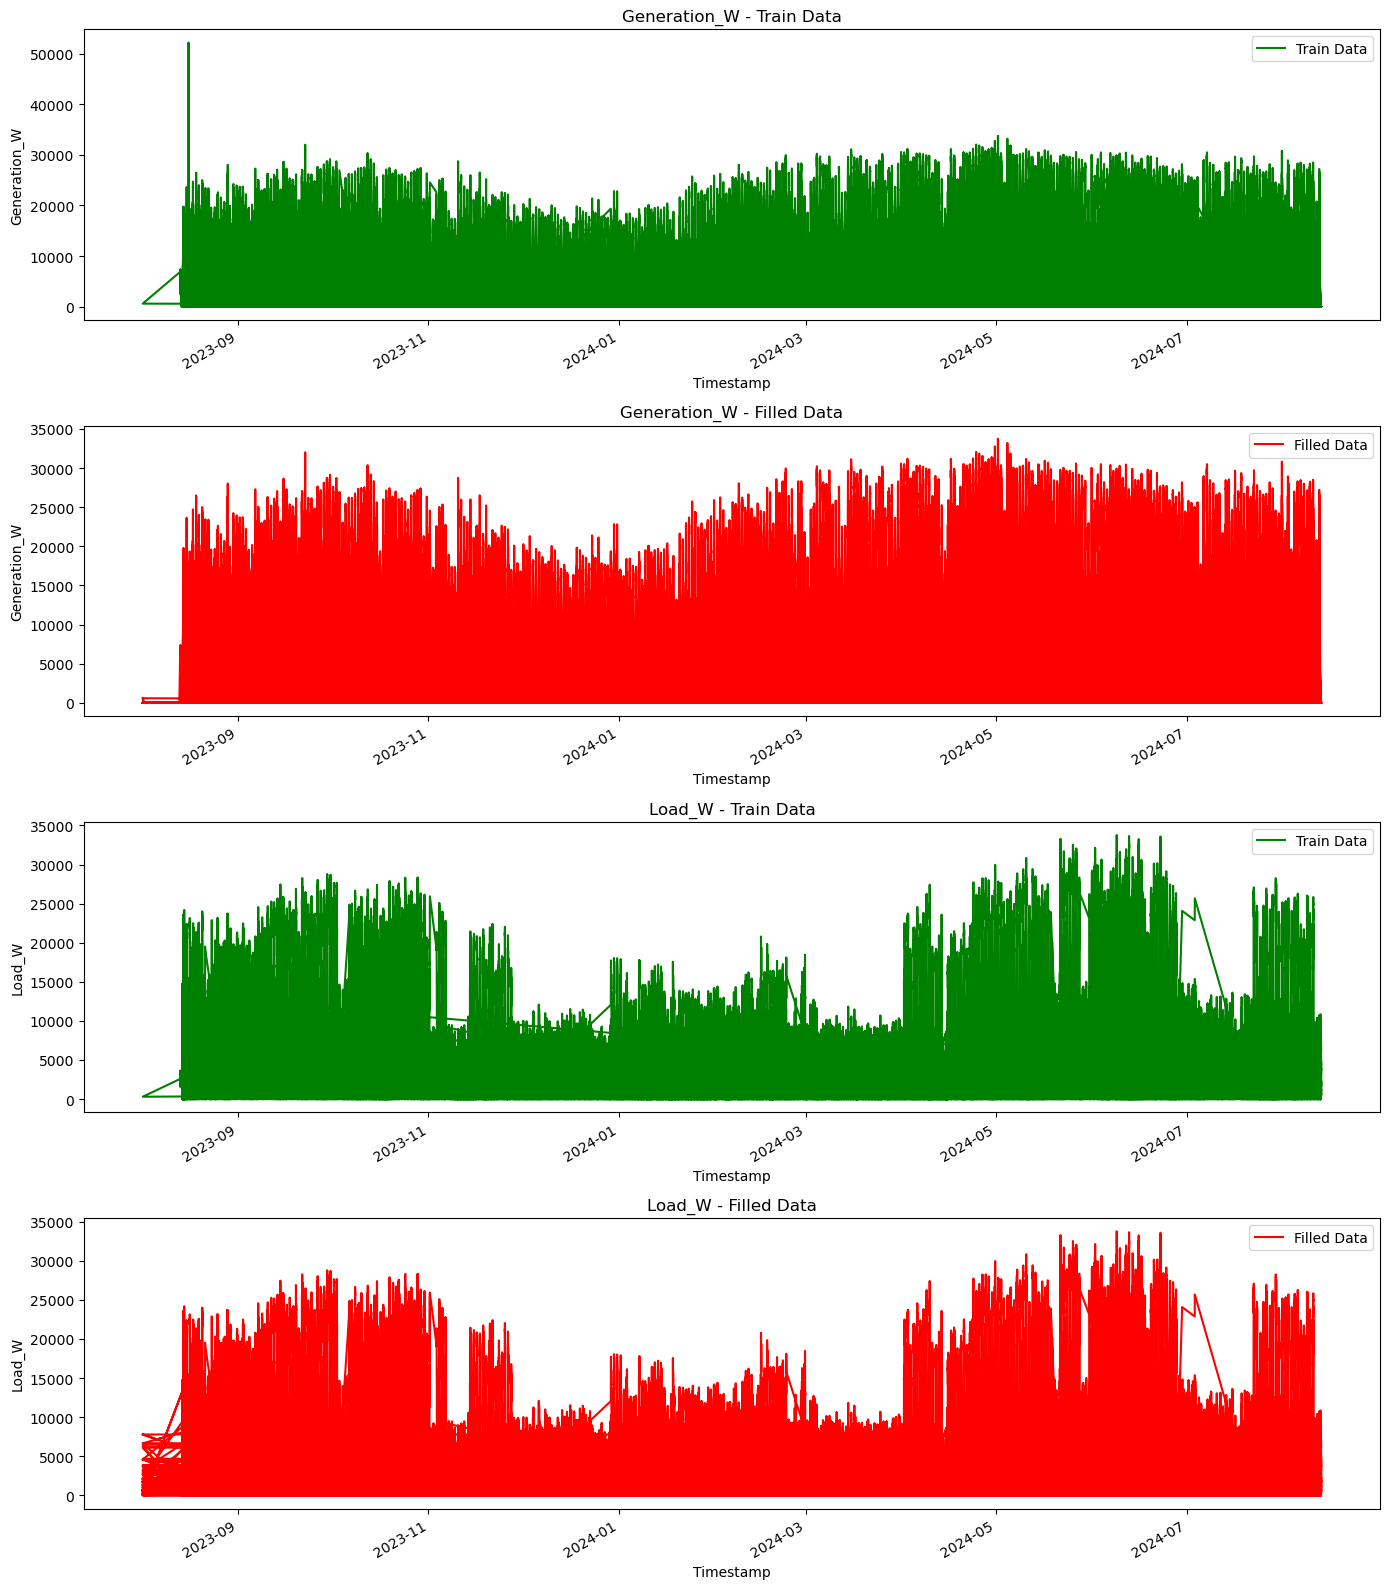

In [62]:
# Create a figure with 4 subplots (4 rows and 1 column)
fig, axs = plt.subplots(4, 1, figsize=(14, 16))

# Plot the original train data for generation_W in the first subplot
train_data.set_index('timestamp')['generation_W'].plot(ax=axs[0], label='Train Data', color='green')
axs[0].set_xlabel('Timestamp')
axs[0].set_ylabel('Generation_W')
axs[0].set_title('Generation_W - Train Data')
axs[0].legend()

# Plot the filled data for generation_W in the second subplot
df_filled.set_index('timestamp')['generation_W'].plot(ax=axs[1], label='Filled Data', color='red')
axs[1].set_xlabel('Timestamp')
axs[1].set_ylabel('Generation_W')
axs[1].set_title('Generation_W - Filled Data')
axs[1].legend()

# Plot the original train data for load_W in the third subplot
train_data.set_index('timestamp')['load_W'].plot(ax=axs[2], label='Train Data', color='green')
axs[2].set_xlabel('Timestamp')
axs[2].set_ylabel('Load_W')
axs[2].set_title('Load_W - Train Data')
axs[2].legend()

# Plot the filled data for load_W in the fourth subplot
df_filled.set_index('timestamp')['load_W'].plot(ax=axs[3], label='Filled Data', color='red')
axs[3].set_xlabel('Timestamp')
axs[3].set_ylabel('Load_W')
axs[3].set_title('Load_W - Filled Data')
axs[3].legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

## Ploting the diff.
The Difference will tells a lot about the residuals that was in the dataset, we have to interpret it.

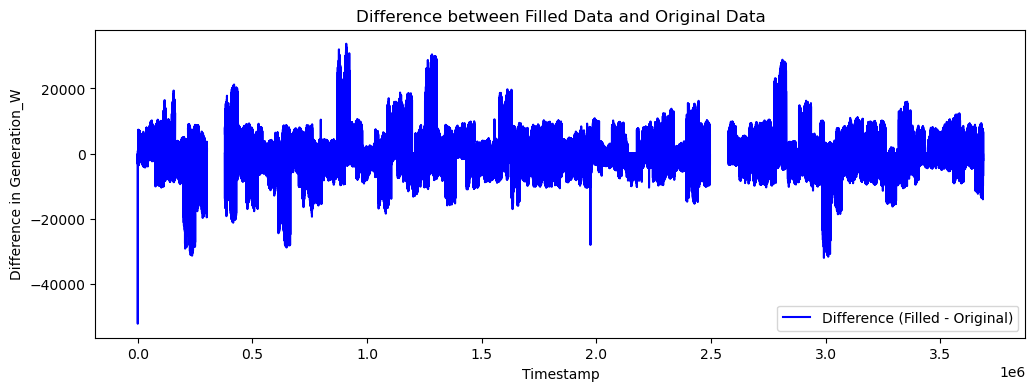

In [64]:
# Calculate the difference between filled data and original data
difference = df_filled['generation_W'] - train_data['generation_W']

# Plot the difference
difference.plot(figsize=(12, 4), label='Difference (Filled - Original)', color='blue')

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Difference in Generation_W')
plt.title('Difference between Filled Data and Original Data')

# Add a legend
plt.legend()

# Show the plot
plt.show()

## Plot the graphs, hourly, it shows us the comple trend, but we have some outliers

In [68]:
# Ensure that 'timestamp' is a datetime object
df_filled['timestamp'] = pd.to_datetime(df_filled['timestamp'])

# Extract the hour from the timestamp
df_filled['hour'] = df_filled['timestamp'].dt.hour

<Figure size 1200x400 with 0 Axes>

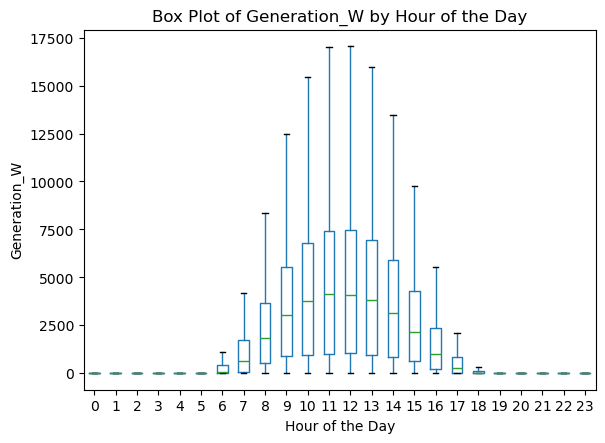

In [70]:
# Create a box plot for generation_W grouped by hour
plt.figure(figsize=(12, 4))
df_filled.boxplot(column='generation_W', by='hour', grid=False, showfliers=False)

# Add labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Generation_W')
plt.title('Box Plot of Generation_W by Hour of the Day')
plt.suptitle('')  # Suppress the automatic boxplot title

# Show the plot
plt.show()

## Saving the File

In [72]:
df_filled.to_csv('df_train_clean.csv', index = False)

In [73]:
df_train_clean = pd.read_csv('df_train_clean.csv')
df_train_clean.head()

,timestamp,system_id,generation_W,load_W,hour
0,2023-08-01 11:00:00,3,586.000030,7784.506767,11
1,2023-08-01 11:10:00,3,573.791696,7783.528568,11
2,2023-08-01 11:20:00,3,561.583362,7782.550369,11
3,2023-08-01 11:30:00,3,549.375028,7781.572170,11
4,2023-08-01 11:40:00,3,537.166694,7780.593972,11


## Now Working with the test data

In [75]:
df_test = pd.read_csv('solar-production-and-load-prediction-competition/test_data_masked.csv')
df_test.isna().sum()

test_id         0
system_id       0
timestamp       0
generation_W    0
load_W          0
dtype: int64

In [77]:
def reindex_per_system_id(df, freq='10min'):
    # Determine the global minimum and maximum timestamp across the entire dataset
    global_min_timestamp = df['timestamp'].min()
    global_max_timestamp = df['timestamp'].max()
    
    # Create the complete global timestamp range
    full_range = pd.date_range(start=global_min_timestamp, end=global_max_timestamp, freq=freq)
    
    reindexed_data = []
    
    # Group by system_id and reindex based on the global full timestamp range for each system
    for system_id, group in df.groupby('system_id'):
        # Reindex the group with the global full timestamp range
        group = group.set_index('timestamp').reindex(full_range)
        
        # Reset the index and add back the system_id
        group = group.reset_index().rename(columns={'index': 'timestamp'})
        group['system_id'] = system_id
        
        reindexed_data.append(group)
    
    # Concatenate all reindexed groups back into a single DataFrame
    return pd.concat(reindexed_data, ignore_index=True)

In [88]:
df_test = pd.read_csv('solar-production-and-load-prediction-competition/test_data_masked.csv')

In [89]:
test_data.duplicated().sum()

0

In [90]:
reindexed_test_df = reindex_per_system_id(df_test)

- Here, we see that, the missing values are alot, and we're unable to handle that much amount, so we'll not play with the test data.

In [94]:
reindexed_test_df.isna().sum()

timestamp             0
test_id         1055060
system_id             0
generation_W    1055060
load_W          1055060
dtype: int64

###### Time to merge the data, the timestamp on which we have masked values an required to predict, that will not be merged.

In [98]:
# Load your train and test data (assuming they are already loaded as DataFrames)
train_df = df_filled
test_df = test_data

# Step 1: Remove the 'test_id' column from the test data
test_df = test_df.drop(columns=['test_id'])

# Step 2: Filter out the rows in the test data where 'generation_W' and 'load_W' are -1 or -2
test_df_filtered = test_df[(test_df['generation_W'] != -1) & (test_df['generation_W'] != -2) &
                           (test_df['load_W'] != -1) & (test_df['load_W'] != -2)]

# Step 3: Concatenate the train and filtered test data horizontally (axis=1)
# Note: This assumes the indices of train and test data align correctly after any filtering or processing.
concatenated_df = pd.concat([train_df.reset_index(drop=True), test_df_filtered.reset_index(drop=True)], axis=0)

In [100]:
concatenated_df.to_csv('Complete Merged File.csv', index = False)

In [102]:
concatenated_df = pd.read_csv('Complete Merged File.csv')

In [103]:
concatenated_df.head(2)

,timestamp,system_id,generation_W,load_W,hour
0,2023-08-01 11:00:00,3,586.000030,7784.506767,11.0
1,2023-08-01 11:10:00,3,573.791696,7783.528568,11.0


In [104]:
# Display the concatenated DataFrame
concatenated_df.drop('hour', axis = 1, inplace = True)

In [105]:
concatenated_df.duplicated().sum()

0

In [106]:
concatenated_df.head(2)

,timestamp,system_id,generation_W,load_W
0,2023-08-01 11:00:00,3,586.000030,7784.506767
1,2023-08-01 11:10:00,3,573.791696,7783.528568


# Time to analyze the Systems file

In [108]:
systems_data = pd.read_csv('solar-production-and-load-prediction-competition/systems_new.csv')

In [109]:
systems_data.duplicated().sum()

2

In [110]:
systems_data = systems_data.drop_duplicates()

In [111]:
systems_data.duplicated().sum()

0

**This is to check the total number of system_ids in the train and test, then in the system file**

In [116]:
concatenated_df['system_id'].nunique()

100

In [117]:
train_data['system_id'].nunique()

80

In [118]:
test_data['system_id'].nunique()

20

In [119]:
systems_data['system_id'].nunique()

107

**Now when we have to know that we don't have all the system_ids in the train and the test; some are extra, so now we'll get access to their index and will remove them, cause it's unnecessary data**

In [121]:
# Get unique system_ids from each DataFrame
system_ids_system = set(systems_data['system_id'].unique())
system_ids_train = set(train_data['system_id'].unique())
system_ids_test = set(test_data['system_id'].unique())

# Combine the system_ids from train and test data
system_ids_train_test = system_ids_train.union(system_ids_test)

# Find system_ids that are in system_data but not in either train_data or test_data
missing_system_ids = system_ids_system - system_ids_train_test

# Output the missing system_ids
if missing_system_ids:
    print("System IDs present in system_data but not in train_data or test_data:")
    print(missing_system_ids)
else:
    print("All system_ids in system_data are present in either train_data or test_data.")

System IDs present in system_data but not in train_data or test_data:
{98, 67, 99, 46, 14, 84, 58}


##### Time to remove

In [123]:
# System IDs to remove
system_ids_to_remove = missing_system_ids

# Filter out the rows with the specified system_ids
system_data_filtered = systems_data[~systems_data['system_id'].isin(system_ids_to_remove)]

# Optionally, save the filtered data to a new CSV file
# system_data_filtered.to_csv('filtered_system_data.csv', index=False)

# Output the filtered data
system_data_filtered.head()

,system_id,connection_type,location,panels_capacity,load_capacity
0,1,RESIDENTIAL,ISLAMABAD,11.125,10.0
1,2,COMMERCIAL,SHEIKHUPURA,5.340,5.5
2,3,RESIDENTIAL,KARACHI,10.350,10.0
3,4,RESIDENTIAL,LAHORE,12.420,10.0
4,5,COMMERCIAL,KARACHI,30.295,20.0


In [124]:
system_data_filtered.nunique()

system_id          100
connection_type      2
location            20
panels_capacity     51
load_capacity        5
dtype: int64

**As we donn't have much features in our dataset, just timestamp and the system_id, so we'll merge the system_id with the our contatenated_df so that the whole data will be created**

In [139]:
df_data = pd.merge(concatenated_df, system_data_filtered, on = 'system_id', how = 'left')

In [141]:
df_data.to_csv('FinalMerged.csv', index=False)

In [142]:
df_data = pd.read_csv('FinalMerged.csv')

In [143]:
df_data.head()

,timestamp,system_id,generation_W,load_W,connection_type,location,panels_capacity,load_capacity
0,2023-08-01 11:00:00,3,586.000030,7784.506767,RESIDENTIAL,KARACHI,10.35,10.0
1,2023-08-01 11:10:00,3,573.791696,7783.528568,RESIDENTIAL,KARACHI,10.35,10.0
2,2023-08-01 11:20:00,3,561.583362,7782.550369,RESIDENTIAL,KARACHI,10.35,10.0
3,2023-08-01 11:30:00,3,549.375028,7781.572170,RESIDENTIAL,KARACHI,10.35,10.0
4,2023-08-01 11:40:00,3,537.166694,7780.593972,RESIDENTIAL,KARACHI,10.35,10.0


In [147]:
df_data.duplicated().sum()

0

In [148]:
concatenated_df.duplicated().sum()

0

In [149]:
systems_data.duplicated().sum()

0

**THe Below Cell of Code will return you the indices of the duplicated, As it's already removed, so no output**

In [151]:
# Get a boolean mask of duplicated rows
duplicated_mask = systems_data.duplicated()

# Get the indices of duplicated rows
duplicated_indices = systems_data[duplicated_mask].index

# Display the indices of the duplicated rows
print(duplicated_indices)

Index([], dtype='int64')


In [152]:
# Get a boolean mask of duplicated rows
duplicated_mask = systems_data.duplicated(keep=False)

# Filter the DataFrame to show only duplicated rows
duplicated_rows = systems_data[duplicated_mask]

# Display the duplicated rows along with their indices
print(duplicated_rows)

Empty DataFrame
Columns: [system_id, connection_type, location, panels_capacity, load_capacity]
Index: []


In [153]:
df_data.head(2)

,timestamp,system_id,generation_W,load_W,connection_type,location,panels_capacity,load_capacity
0,2023-08-01 11:00:00,3,586.000030,7784.506767,RESIDENTIAL,KARACHI,10.35,10.0
1,2023-08-01 11:10:00,3,573.791696,7783.528568,RESIDENTIAL,KARACHI,10.35,10.0


**Just to see the `KARACHI` loation in the dataset.**

In [155]:
df_data[df_data['location'] == 'KARACHI'].head()

,timestamp,system_id,generation_W,load_W,connection_type,location,panels_capacity,load_capacity
0,2023-08-01 11:00:00,3,586.000030,7784.506767,RESIDENTIAL,KARACHI,10.35,10.0
1,2023-08-01 11:10:00,3,573.791696,7783.528568,RESIDENTIAL,KARACHI,10.35,10.0
2,2023-08-01 11:20:00,3,561.583362,7782.550369,RESIDENTIAL,KARACHI,10.35,10.0
3,2023-08-01 11:30:00,3,549.375028,7781.572170,RESIDENTIAL,KARACHI,10.35,10.0
4,2023-08-01 11:40:00,3,537.166694,7780.593972,RESIDENTIAL,KARACHI,10.35,10.0


# Feature Engineering

**These are the weather data of each city in the `location` downloaded from `Meteostate.net`**

In [158]:
df_karachi = pd.read_csv('karachi.csv')
df_lahore = pd.read_csv('lahore_city.csv')
df_islamabad = pd.read_csv('islamabad.csv')
df_hyderabad = pd.read_csv('Hyderabad.csv')
df_sialkot = pd.read_csv('sialkot.csv')
df_multan = pd.read_csv('multan.csv')
df_mardan = pd.read_csv('mardan.csv')
df_gujranwala = pd.read_csv('gujranwala.csv')
df_sukkur = pd.read_csv('sukkur.csv')
df_dera_ismail_khan = pd.read_csv("DI khan.csv")
df_peshawar = pd.read_csv('peshawar.csv')
df_kamra = pd.read_csv('kamra.csv')
df_swat = pd.read_csv('swat.csv')
df_rawalpindi = pd.read_csv('rawalpindi.csv')
df_faisalabad = pd.read_csv('faisalabad.csv')
df_quetta = pd.read_csv('quetta.csv')
df_larkana = pd.read_csv('larkana.csv')
df_pattoki = pd.read_csv('pattoki.csv')
df_sheikhupura = pd.read_csv('lahore.csv')
df_abbottabad = pd.read_csv('abbottabad.csv')

In [167]:
df_karachi = pd.read_csv('karachi.csv')
df_karachi.head(2)

,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2023-08-01,28.6,27.1,30.5,0.6,NaN,249,31.2,NaN,1000.3,NaN
1,2023-08-02,28.6,26.9,30.7,0.4,NaN,247,33.3,NaN,1000.3,NaN


In [169]:
df_karachi.drop(['snow', 'tsun', 'wpgt'], axis = 1, inplace = True)

In [171]:
df_karachi.isna().sum()

date    0
tavg    0
tmin    0
tmax    0
prcp    0
wdir    0
wspd    0
pres    0
dtype: int64

**The weather accross each city downloaded from the earlier mentioned Web, now it's time to merge it with the data, The weather data will be merged wrt to the location of each system_id**

In [174]:
# Convert the 'timestamp' and 'date' columns to datetime format
df_data['timestamp'] = pd.to_datetime(df_data['timestamp'])
df_data['date'] = df_data['timestamp'].dt.date
df_data['date'] = pd.to_datetime(df_data['date'])

# List of cities and locations to process
cities = ['KARACHI', 'LAHORE', 'ISLAMABAD', 'HYDERABAD', 'SIALKOT', 'MULTAN',
          'MARDAN', 'GUJRANWALA', 'SUKKUR', 'DERA ISMAIL KHAN', 'PESHAWAR',
          'KAMRA', 'SWAT', 'RAWALPINDI', 'FAISALABAD', 'QUETTA', 'LARKANA',
          'PATTOKI', 'SHEIKHUPURA', 'ABBOTTABAD']

# Initialize an empty list to store DataFrames for each city
merged_data_list = []

# Iterate over each city and perform the merging and concatenation
for city in cities:
    # Replace spaces with underscores to match variable names
    city_var_name = f'df_{city.lower().replace(" ", "_")}'
    
    # Load the city's specific DataFrame
    try:
        df_city = globals()[city_var_name]
    except KeyError:
        print(f"DataFrame for {city} not found.")
        continue
    
    # Convert the 'date' column to datetime in the city's DataFrame
    df_city['date'] = pd.to_datetime(df_city['date'])
    
    # Drop the unnecessary columns if they exist
    columns_to_drop = ['snow', 'tsun', 'wpgt']
    df_city.drop(columns=[col for col in columns_to_drop if col in df_city.columns], axis=1, inplace=True)
    
    # Interpolate missing values using the linear method
    df_city.interpolate(method='linear', inplace=True)
    
    # Filter the main data for the current city
    city_data = df_data[df_data['location'] == city]
    
    # Merge the city-specific data with the filtered main data on 'date'
    merged_city_data = pd.merge(city_data, df_city, how='left', on='date')
    
    # Append the merged data to the list
    merged_data_list.append(merged_city_data)

# Concatenate all the city DataFrames along the vertical axis (rows)
final_concatenated_df = pd.concat(merged_data_list, axis=0, ignore_index=True)

# Output the final DataFrame
final_concatenated_df.head()

,timestamp,system_id,generation_W,load_W,connection_type,location,panels_capacity,load_capacity,date,tavg,tmin,tmax,prcp,wdir,wspd,pres
0,2023-08-01 11:00:00,3,586.000030,7784.506767,RESIDENTIAL,KARACHI,10.35,10.0,2023-08-01,28.6,27.1,30.5,0.6,249.0,31.2,1000.3
1,2023-08-01 11:10:00,3,573.791696,7783.528568,RESIDENTIAL,KARACHI,10.35,10.0,2023-08-01,28.6,27.1,30.5,0.6,249.0,31.2,1000.3
2,2023-08-01 11:20:00,3,561.583362,7782.550369,RESIDENTIAL,KARACHI,10.35,10.0,2023-08-01,28.6,27.1,30.5,0.6,249.0,31.2,1000.3
3,2023-08-01 11:30:00,3,549.375028,7781.572170,RESIDENTIAL,KARACHI,10.35,10.0,2023-08-01,28.6,27.1,30.5,0.6,249.0,31.2,1000.3
4,2023-08-01 11:40:00,3,537.166694,7780.593972,RESIDENTIAL,KARACHI,10.35,10.0,2023-08-01,28.6,27.1,30.5,0.6,249.0,31.2,1000.3


In [175]:
final_concatenated_df.duplicated().sum()

0

In [176]:
final_concatenated_df.isna().sum().sum()

0

In [177]:
# Save the DataFrame to a CSV file without the index
final_concatenated_df.to_csv('Train.csv', index=False)

In [178]:
train_data = pd.read_csv('Train.csv')
train_data.head()

,timestamp,system_id,generation_W,load_W,connection_type,location,panels_capacity,load_capacity,date,tavg,tmin,tmax,prcp,wdir,wspd,pres
0,2023-08-01 11:00:00,3,586.000030,7784.506767,RESIDENTIAL,KARACHI,10.35,10.0,2023-08-01,28.6,27.1,30.5,0.6,249.0,31.2,1000.3
1,2023-08-01 11:10:00,3,573.791696,7783.528568,RESIDENTIAL,KARACHI,10.35,10.0,2023-08-01,28.6,27.1,30.5,0.6,249.0,31.2,1000.3
2,2023-08-01 11:20:00,3,561.583362,7782.550369,RESIDENTIAL,KARACHI,10.35,10.0,2023-08-01,28.6,27.1,30.5,0.6,249.0,31.2,1000.3
3,2023-08-01 11:30:00,3,549.375028,7781.572170,RESIDENTIAL,KARACHI,10.35,10.0,2023-08-01,28.6,27.1,30.5,0.6,249.0,31.2,1000.3
4,2023-08-01 11:40:00,3,537.166694,7780.593972,RESIDENTIAL,KARACHI,10.35,10.0,2023-08-01,28.6,27.1,30.5,0.6,249.0,31.2,1000.3


**Checking the Missing Values from the final output**

In [185]:
# Get the indices where there are missing values in the final DataFrame
missing_indices = final_concatenated_df[final_concatenated_df.isna().any(axis=1)].index

# Output the indices
print("Indices with missing values:")
print(missing_indices)

Indices with missing values:
Index([], dtype='int64')


In [186]:
final_concatenated_df.loc[missing_indices]

,timestamp,system_id,generation_W,load_W,connection_type,location,panels_capacity,load_capacity,date,tavg,tmin,tmax,prcp,wdir,wspd,pres


**Now with the Test Data Masked**

In [190]:
test_data = pd.read_csv('solar-production-and-load-prediction-competition/test_data_masked.csv')
test_data.head()

,test_id,system_id,timestamp,generation_W,load_W
0,QNN8B4SF,39,2023-08-12 17:40:00,2770.28574,3410.08823
1,2XFLJU7J,39,2023-08-12 17:50:00,2198.08336,3183.79486
2,ZTXR24I5,39,2023-08-12 18:00:00,1801.88889,2743.21568
3,AE6LFBMV,39,2023-08-12 18:10:00,1419.09090,1630.29630
4,RSDMSDW2,39,2023-08-12 18:20:00,897.99999,1788.60000


In [191]:
df_test = pd.merge(test_data, systems_data, on='system_id', how='left')
df_test.head()

,test_id,system_id,timestamp,generation_W,load_W,connection_type,location,panels_capacity,load_capacity
0,QNN8B4SF,39,2023-08-12 17:40:00,2770.28574,3410.08823,COMMERCIAL,HYDERABAD,25.2,20.0
1,2XFLJU7J,39,2023-08-12 17:50:00,2198.08336,3183.79486,COMMERCIAL,HYDERABAD,25.2,20.0
2,ZTXR24I5,39,2023-08-12 18:00:00,1801.88889,2743.21568,COMMERCIAL,HYDERABAD,25.2,20.0
3,AE6LFBMV,39,2023-08-12 18:10:00,1419.09090,1630.29630,COMMERCIAL,HYDERABAD,25.2,20.0
4,RSDMSDW2,39,2023-08-12 18:20:00,897.99999,1788.60000,COMMERCIAL,HYDERABAD,25.2,20.0


In [192]:
df_test.duplicated().sum()

0

In [193]:
df_test.isna().sum()

test_id            0
system_id          0
timestamp          0
generation_W       0
load_W             0
connection_type    0
location           0
panels_capacity    0
load_capacity      0
dtype: int64

In [198]:
# Convert the 'timestamp' and 'date' columns to datetime format
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
df_test['date'] = df_test['timestamp'].dt.date
df_test['date'] = pd.to_datetime(df_test['date'])

# List of cities and locations to process
cities = ['KARACHI', 'LAHORE', 'ISLAMABAD', 'HYDERABAD', 'SIALKOT', 'MULTAN',
          'MARDAN', 'GUJRANWALA', 'SUKKUR', 'DERA ISMAIL KHAN', 'PESHAWAR',
          'KAMRA', 'SWAT', 'RAWALPINDI', 'FAISALABAD', 'QUETTA', 'LARKANA',
          'PATTOKI', 'SHEIKHUPURA', 'ABBOTTABAD']

# Initialize an empty list to store DataFrames for each city
merged_data_list = []

# Iterate over each city and perform the merging and concatenation
for city in cities:
    # Replace spaces with underscores to match variable names
    city_var_name = f'df_{city.lower().replace(" ", "_")}'
    
    # Load the city's specific DataFrame
    try:
        df_city = globals()[city_var_name]
    except KeyError:
        print(f"DataFrame for {city} not found.")
        continue
    
    # Convert the 'date' column to datetime in the city's DataFrame
    df_city['date'] = pd.to_datetime(df_city['date'])
    
    # Drop the unnecessary columns if they exist
    columns_to_drop = ['snow', 'tsun', 'wpgt']
    df_city.drop(columns=[col for col in columns_to_drop if col in df_city.columns], axis=1, inplace=True)
    
    # Interpolate missing values using the linear method
    df_city.interpolate(method='linear', inplace=True)
    
    # Filter the main data for the current city
    city_data = df_test[df_test['location'] == city]
    
    # Merge the city-specific data with the filtered main data on 'date'
    merged_city_data = pd.merge(city_data, df_city, how='left', on='date')
    
    # Append the merged data to the list
    merged_data_list.append(merged_city_data)

# Concatenate all the city DataFrames along the vertical axis (rows)
final_concatenated_df_test = pd.concat(merged_data_list, axis=0, ignore_index=True)

# Output the final DataFrame
final_concatenated_df_test.head()

,test_id,system_id,timestamp,generation_W,load_W,connection_type,location,panels_capacity,load_capacity,date,tavg,tmin,tmax,prcp,wdir,wspd,pres
0,8RLHZP9Q,32,2023-08-14 02:00:00,0.0,1954.66668,RESIDENTIAL,KARACHI,10.465,10.0,2023-08-14,27.6,25.8,30.3,0.0,244.0,29.8,1001.2
1,AOOUUP1G,32,2023-08-14 02:10:00,0.0,1947.90000,RESIDENTIAL,KARACHI,10.465,10.0,2023-08-14,27.6,25.8,30.3,0.0,244.0,29.8,1001.2
2,IBSBTOSB,32,2023-08-14 02:20:00,0.0,1952.20003,RESIDENTIAL,KARACHI,10.465,10.0,2023-08-14,27.6,25.8,30.3,0.0,244.0,29.8,1001.2
3,7VMO18VY,32,2023-08-14 02:30:00,0.0,1938.77778,RESIDENTIAL,KARACHI,10.465,10.0,2023-08-14,27.6,25.8,30.3,0.0,244.0,29.8,1001.2
4,L84NT3BS,32,2023-08-14 02:40:00,0.0,1890.39999,RESIDENTIAL,KARACHI,10.465,10.0,2023-08-14,27.6,25.8,30.3,0.0,244.0,29.8,1001.2


In [199]:
final_concatenated_df_test.isna().sum().sum()

0

In [200]:
final_concatenated_df_test.duplicated().sum()

0

In [201]:
final_concatenated_df_test.to_csv('Test.csv', index = False)

In [203]:
df_test = pd.read_csv('Test.csv')
df_test.head()

,test_id,system_id,timestamp,generation_W,load_W,connection_type,location,panels_capacity,load_capacity,date,tavg,tmin,tmax,prcp,wdir,wspd,pres
0,8RLHZP9Q,32,2023-08-14 02:00:00,0.0,1954.66668,RESIDENTIAL,KARACHI,10.465,10.0,2023-08-14,27.6,25.8,30.3,0.0,244.0,29.8,1001.2
1,AOOUUP1G,32,2023-08-14 02:10:00,0.0,1947.90000,RESIDENTIAL,KARACHI,10.465,10.0,2023-08-14,27.6,25.8,30.3,0.0,244.0,29.8,1001.2
2,IBSBTOSB,32,2023-08-14 02:20:00,0.0,1952.20003,RESIDENTIAL,KARACHI,10.465,10.0,2023-08-14,27.6,25.8,30.3,0.0,244.0,29.8,1001.2
3,7VMO18VY,32,2023-08-14 02:30:00,0.0,1938.77778,RESIDENTIAL,KARACHI,10.465,10.0,2023-08-14,27.6,25.8,30.3,0.0,244.0,29.8,1001.2
4,L84NT3BS,32,2023-08-14 02:40:00,0.0,1890.39999,RESIDENTIAL,KARACHI,10.465,10.0,2023-08-14,27.6,25.8,30.3,0.0,244.0,29.8,1001.2
